In [1]:
# 가우스 잡음 추가 함수
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

/var/folders/1l/rpxsxc3j1b15kw96kqt86gh80000gn/T/ipykernel_7134/3987532287.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
/var/folders/1l/rpxsxc3j1b15kw96kqt86gh80000gn/T/ipykernel_7134/3987532287.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x , dtype=torch.float32)


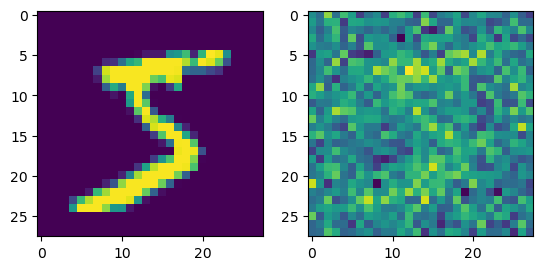

In [2]:
def gaussian_noise(x , scale=0.8):
    gaussian_data_x = x + np.random.normal(
        loc = 0 , scale=scale , size = x.shape
    )
    gaussian_data_x = np.clip(gaussian_data_x)
    gaussian_data_x = torch.tensor(gaussian_data_x , dtype=torch.float32)
    return gaussian_data_x

train_data = MNIST(root='./' , train=True , download=True , transform=ToTensor())
test_data = MNIST(root='./' , train=False , download=True , transform=ToTensor())

img , label = next(iter(train_data))
img
gaussian = gaussian_noise(img)
gaussian

img = img.permute(1,2,0)
gaussian = gaussian.permute(1,2,0)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(gaussian)

In [3]:
for data , label in train_data:
    noisy = gaussian_noise(data)
    print(type(noisy),noisy.size())
    break

<class 'torch.Tensor'> torch.Size([1, 28, 28])


/var/folders/1l/rpxsxc3j1b15kw96kqt86gh80000gn/T/ipykernel_7134/3987532287.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gaussian_data_x = x + np.random.normal(
/var/folders/1l/rpxsxc3j1b15kw96kqt86gh80000gn/T/ipykernel_7134/3987532287.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gaussian_data_x = torch.tensor(gaussian_data_x , dtype=torch.float32)


In [4]:
# 학습용 데이터셋
from torch.utils.data.dataset import Dataset
class Denise(Dataset):
    def __init__(self):
        self.mnist = train_data = MNIST(root='./' , train=True , download=True , transform=ToTensor())
        self.data = []
        # 잡음 입히기
        for data , label in self.mnist:
            noisy = gaussian_noise(data)
            self.data.append(noisy.unsqueeze(0)) # (1(channel),1(h),28(w),28(w))
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        data = self.data[index]
        label = self.mnist.data[index] / 255 # 원본 이미지도 0~1 정규화
        return data , label

In [5]:
# 합성곱 기본 블럭
# conv -> relu -> conv -> relu
import torch.nn as nn
class BasicBlock(nn.Module):
    def __init__(self,in_channel , out_channel , hidden_channel):
        super(BasicBlock,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel ,  hidden_channel , kernel_size=3 , padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel ,  out_channel , kernel_size=3 , padding=1),
            nn.ReLU()
        )
    def forward(self, x):
        return self.model(x)
# sample_data = torch.randn(1,1,28,28)
# sample_model = BasicBlock(1,20,10)
# sample_model(sample_data).size()

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,8,8)
        self.pool = nn.AvgPool2d(2)
    def forward(self, x):
        x = self.pool(self.conv1(x)) # 1 , 16 , 14 , 41
        out = self.pool(self.conv2(x)) # 1 , 8 , 7 , 7
        return out

In [7]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        # 출력층
        self.conv3 = nn.Conv2d(16,1,kernel_size=3,padding=1)
        # 어셈플링 층
        self.upsampling1 = nn.ConvTranspose2d(8,8,kernel_size=2 , stride=2)
        self.upsampling2 = nn.ConvTranspose2d(16,16,kernel_size=2 , stride=2)
    def forward(self, x):
        x = self.upsampling1(self.conv1(x))
        x = self.upsampling2(self.conv2(x))
        out = self.conv3(x)
        return out

In [8]:
d = Decoder()
d(Encoder).size()

TypeError: conv2d() received an invalid combination of arguments - got (type, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!type!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!type!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


In [ ]:
# CAE 모델로 Auto Encoder 연결할꺼임.
# Decoder 와 Encoder 를 연결 : 인코더의 출력을 디코더의 입력으로 제공
class CAE(nn.Module):
    def __init__(self):
        super(CAE , self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()
    def forward(self,x):
        x = self.enc(x)
        x = self.dec(x)
        return x